## Analyzing the New York subway dataset
#### Vivek Yadav, PhD. 

### Section 0: References.

##### Data Source:
Data were downloaded from the links for Udacity project to analyze subway data. 
Original data set: https://www.dropbox.com/s/meyki2wl9xfa7yk/turnstile_data_master_with_weather.csv
Improved data set: https://www.dropbox.com/s/1lpoeh2w6px4diu/improved-dataset.zip?dl=0
Code book/Variables: https://s3.amazonaws.com/uploads.hipchat.com/23756/665149/05bgLZqSsMycnkg/turnstile-weather-variables.pdf

### Section 1. Statisical Modeling


####1.1 Which statistical test did you use to analyze the NYC subway data? Did you use a one-tail or a two-tail P value? What is the null hypothesis? What is your p-critical value?

####Response: 
As the distribution is not normal, we use Mann-Whitney u-test also Wilcoxon test. However, as the number of data points is much larger than 50, a two-tail welch's t-test is also applicable. So results for both are reported. P-critical (or $\alpha$) was 0.05, i.e. if the statistical test gave p-value less than 0.05 the null hypothesis will be rejected. 


Null hypothesis: Subway ridership is not affected on a given day if it rains or not. Operationally, rainy and non-rainy days have the same POPULATION mean. ($\mu_{rain} = \mu_{no ~rain} $)

Alternate hypothesis: Subway ridership is affected on a given day if it rains or not. Operationally, rainy and non-rainy days have different POPULATION mean. ($\mu_{rain} \neq \mu_{no ~rain} $)

####1.2 Why is this statistical test applicable to the dataset? In particular, consider the assumptions that the test is making about the distribution of ridership in the two samples.

####Response: 
As the distribution is not normal, we use Mann-Whitney u-test also Wilcoxon test. However, as the number of data points is much larger than 50, a two-tail welch's t-test is also applicable. So results for both are reported. P-critical was 0.05, i.e. if the statistical test gave p-value less than 0.05 the null hypothesis will be rejected. 

### Statistical tests

Populating the interactive namespace from numpy and matplotlib


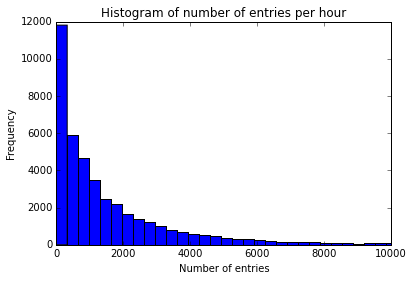

In [24]:
### EXPLORATORY ANALYSIS
## First we check if the data is normally distributed.
## importing packages
import pandas as pd
import numpy as np

import scipy.stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.cross_validation import train_test_split

%pylab inline


## READING data

path = '~/Desktop/DataSc_Udacity/P2/turnstile_weather_v2.csv'
turnstile_weather = pd.read_csv(path)


ind_rain = turnstile_weather['rain']==0
ind_nrain = turnstile_weather['rain']==1

plt.figure()
plt.xlim(0,10000)
plt.xlabel('Number of entries')
plt.ylabel('Frequency')
plt.title('Histogram of number of entries per hour')
n, bins, patches = plt.hist(turnstile_weather['ENTRIESn_hourly'], 100)


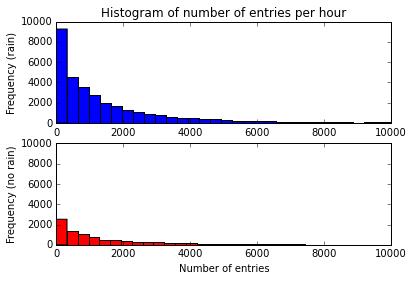

In [25]:
data_rain = np.asarray(turnstile_weather['ENTRIESn_hourly'][ind_rain])
data_nrain = np.asarray(turnstile_weather['ENTRIESn_hourly'][ind_nrain])

plt.subplot(2,1,1)
plt.xlim(0,10000)
plt.ylim(0,10000)
plt.ylabel('Frequency (rain)')
plt.title('Histogram of number of entries per hour')
n, bins, patches = plt.hist(data_rain, 100)
plt.subplot(2,1,2)
plt.xlim(0,10000)
plt.ylim(0,10000)
plt.xlabel('Number of entries ')
plt.ylabel('Frequency (no rain)')
n, bins, patches = plt.hist(data_nrain, 100,color ='red')

In [26]:
w, p_shapiro = scipy.stats.shapiro(turnstile_weather['ENTRIESn_hourly'])
print('Shapiro wilk test for normality: w = ' + str(w) + ' , p = ' + str(p_shapiro))

Shapiro wilk test for normality: w = 0.5943876504898071 , p = 0.0


In [27]:
## Result from Mann-whitney U-test
U, P_mannWht = scipy.stats.mannwhitneyu(data_rain,data_nrain)
print('Mann Whitney U-test: U = ' + str(U) + ' , p = ' + str(P_mannWht))

Mann Whitney U-test: U = 153635120.5 , p = 2.74106957124e-06


In [28]:
## Result from two sided Welch t-test
t_stat, p_ttest = scipy.stats.ttest_ind( data_rain,data_nrain,equal_var = False)
m1 = data_rain.mean()
m2 = data_nrain.mean()
print([m1,m2])
s1 = data_rain.std()
s2 = data_nrain.std()
n1 = len(data_rain)
n2 = len(data_nrain)

s = sqrt( s1**2/n1 + s2**2/n2 )

# combined degrees of freedom
mu_cb = (s1**2/n1 + s2**2/n2)**2/ (s1**4/(n1**2 * (n1-1)) + s2**4/(n2**2 * (n2-1)))

mu = m1-m2
ci_int = scipy.stats.t.ppf(1-.025, mu_cb)
ci_low = mu - ci_int*s/sqrt(mu_cb+1)
ci_upr = mu + ci_int*s/sqrt(mu_cb+1)
ci = [ci_low,ci_upr]
print(ci)


t_critical = scipy.stats.t.isf(0.025, mu_cb)
print('Two-sided welch t-test: t_statistics = ' + str(t_stat) + ', t_critical = ' + str(t_critical) + ' , p = ' + str(p_ttest))


[1845.5394386644084, 2028.1960354720918]
[-183.24792973495676, -182.06526388041004]
Two-sided welch t-test: t_statistics = -5.04288274762, t_critical = 1.96012859275 , p = 4.64140243163e-07


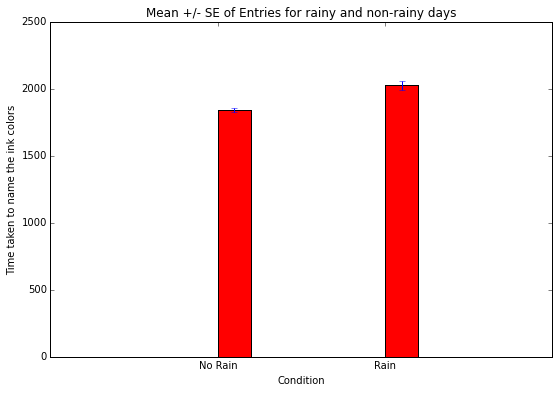

In [29]:
turnstile_weather_short = turnstile_weather.loc[:,['rain','ENTRIESn_hourly']]
turnstile_weather_short_sd = turnstile_weather_short.groupby(['rain']).std().reset_index()
turnstile_weather_short_ct = turnstile_weather_short.groupby(['rain']).count().reset_index()
turnstile_weather_short = turnstile_weather_short.groupby(['rain']).mean().reset_index()

turnstile_weather_short['SE_ENTRIESn_hourly'] = turnstile_weather_short_sd.ENTRIESn_hourly/sqrt(turnstile_weather_short_ct.ENTRIESn_hourly)
turnstile_weather_short

x = [.25,.75]
y = [turnstile_weather_short['ENTRIESn_hourly'][0],turnstile_weather_short['ENTRIESn_hourly'][1]]
yerr = [turnstile_weather_short['SE_ENTRIESn_hourly'][0],turnstile_weather_short['SE_ENTRIESn_hourly'][1]]

rain_mean_SE = turnstile_weather_short
fig1 = plt.figure(2, figsize=(9, 6))
plt.bar(x, y, .1, color='r',yerr=yerr)
ax1 = fig1.add_subplot(111)
ax1.set_xticks([.25,.75])
ax1.set_xticklabels(['No Rain', 'Rain'])
ax1.set_xlabel('Condition')
ax1.set_ylabel('Time taken to name the ink colors')
ax1.set_ylim(0, 2500)
ax1.set_xlim(-.25, 1.25)
ax1.set_title('Mean +/- SE of Entries for rainy and non-rainy days')

####1.3 What results did you get from this statistical test? These should include the following numerical values: p-values, as well as the means for each of the two samples under test.

Mean+/-Standard error of ridership on rainy days is $2028+/-32.6$ and on non-rainy days is $1845+/-15.8$. These results suggest than mean ridership is higher on rainy days. We next compare them using statistcal tests. 

####Response
#### Shapiro test of normality.
Shapiro test of normality gave $p = 0.0<<< 0.05$. As the null assumption for this test is that the underlying distribution is normal, we reject the null hypothesis because $p<<<0.05$. Therefore, the underlying distribution is not normal, however, as number of points is greater than 50, welch's t-test is also applicable. Therefore, we first use Mann-Whiteny U-test and then Welch's t-test. 

#### Mann-Whiteny U-test: 
Mann-Whitney U-test gave a U-statistic of $153635120.5$ with a $p\approx 2.65*10^{-6}<< 0.05$. As p-value was less than the critical value, the null hypothesis is rejected, i.e. the ridership varies with rain.

####Welch t-test: 
As the number of data points is much larger than 50, a two-tail Welch's t-test is also applicable. From paired two-tail t-test, it appears that the t-statistic was -21.5 and t_critical was 1.96. As the absolute value of t-statistic (5.04) is greater than the critical value (1.96), we conclude that the difference is significant. Futher, the associated $p-value$ was very small ($p \approx 5*10^{-7} << 0.05$). As the $p-value$ was less than the threshold ($\alpha = 0.05$), we reject the null hypothesis. These together indicate that the observed differences are significant, i.e. null hypothesis is to be rejected, i.e. the ridership varies with rain. Further, as p-value for one sided test is half of two sided, it implies that the ridership is higher on rainy days. 

Next confidence interval is computed. Confidence interval is between the ranges of 182 and 183.25, i.e. with 95% confidence we can state that the difference between the rainy and non-rainy days is between 182 and 183.25. As 0 does not lie within the confidence interval, we conclude that the observed differences are significant and the null hypothesis should be rejected. 

Rain has a significant effect on ridership. Ridership is higher on rainy days. 

### Section 2. Linear Regression
####2.1 What approach did you use to compute the coefficients theta and produce prediction for ENTRIESn_hourly in your regression model:
####Response: 
Linear regression was used to model relation between features and the data. However, as the data were not distributed normally, a log transform was applied to the dependent measures. However, some of the entries in the data were 0, and log(x) resulted in NaN or Inf values. Therefore, number of entries was transformed into log scale as log(1+x). This is a valid transform, because this results in a one to one transformation. These transformed values of the number of hourly entries were the dependent measure for regression.

####2.2 What features (input variables) did you use in your model? Did you use any dummy variables as part of your features?
####Response: 
Features used in the model are, 
1. Rain: (0/1) indicating if it was raining on that particular day or not.
2. Precipi: Total rainfall during hour.
3. tempi: Temperature at the time of entry. 
4. weekday: (0/1) Indicating if the day is weekday (mon-fri) or a weekend. 

In addition, there were 4 dummy variables included to account for 
1. unit: Unit number at which entry was made.  
2. day_week: Day of the week. Added this as dummy variable because day_week goes from 0 to 6, however, this ordering  does not correlate to ridership. Further, it is anticipated that ridership will be higher during rush hours and lower during 
3. hour: Hour at which entry was made. Hour was taken as a dummy variable, this ordering  does not correlate to ridership
4. Unithour: Unithour represents interaction between unit and hours. It is expected that some stations/units will have peak activity during certain hours. For example, if we take the case of people traveling to new york. Stations farther away from New york are expected to have rush hour during earlier hours, where as stations closer to new york are expected to have more users in hours closer to work hours.

In [30]:
c = ', '.join('%s-%s' % t for t in zip(turnstile_weather['UNIT'], turnstile_weather['hour']))
c = c.split(',')
turnstile_weather['Unithour'] = c

c = ', '.join('%s-%s' % t for t in zip(turnstile_weather['Unithour'], turnstile_weather['weekday']))
c = c.split(',')
turnstile_weather['UnithourWD'] = c
c = ', '.join('%s-%s' % t for t in zip(turnstile_weather['rain'], turnstile_weather['weekday']))
c = c.split(',')
turnstile_weather['rainWD'] = c

features = turnstile_weather[['rain','precipi','tempi','weekday']]
dummy_units = pd.get_dummies(turnstile_weather['UNIT'], prefix='unit')
features = features.join(dummy_units)
#dummy_units = pd.get_dummies(turnstile_weather['day_week'], prefix='day_week')
#features = features.join(dummy_units)
#dummy_units = pd.get_dummies(turnstile_weather['hour'], prefix='hour')
#features = features.join(dummy_units)
#dummy_units = pd.get_dummies(turnstile_weather['Unithour'], prefix='Unithour')
#features = features.join(dummy_units)
#dummy_units = pd.get_dummies(turnstile_weather['UnithourWD'], prefix='UnithourWD')
#features = features.join(dummy_units)
#dummy_units = pd.get_dummies(turnstile_weather['rainWD'], prefix='rainWD')
#features = features.join(dummy_units)

print('Number of Features is ' + str(features.shape[1]))
values = turnstile_weather['ENTRIESn_hourly']
print(type(values))

Number of Features is 244
<class 'pandas.core.series.Series'>


In [31]:
X = features
Y = np.log(values+1)
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results_full = results
intercept = results.params[0]
params = results.params[1:len(results.params)]
predictions = intercept + np.dot(features, params)



0.30350856185
42649
rain       0.286592
precipi   -2.847745
tempi      0.037530
weekday    0.629080
dtype: float64


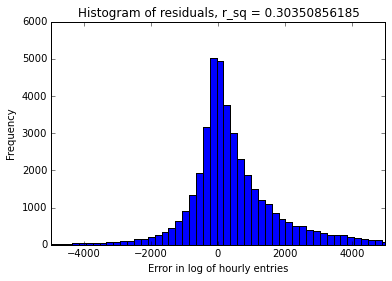

In [32]:
Y = np.log(values+1)

y_mi_ybar = np.exp(Y) - np.mean(np.exp(Y))
y_mi_pred = np.exp(Y) - np.exp(predictions)
r_squared = 1 - np.sum(y_mi_pred**2)/np.sum(y_mi_ybar**2)
print(r_squared)
print(len(Y))

print(results_full.params[1:5])
plt.figure()
n, bins, patches = plt.hist(np.asarray(y_mi_pred),200)
plt.xlabel('Error in log of hourly entries')
plt.ylabel('Frequency')
plt.xlim(-5000,5000)
plt.title('Histogram of residuals, r_sq = ' + str(r_squared))

As $R^{2}=0.858$ was very high, there is chance that the data may have been over fitted. Therefore, as a sanity check, another linear regression model is fitted to half of the data randomly sampled from the same data set and tested on the other half. 

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=0)


In [34]:
model = sm.OLS(Y_train,X_train)
results = model.fit()
intercept = results.params[0]
params = results.params[1:len(results.params)]
predictions_train = np.dot(X_train, results.params)


R-sq for training set = 0.305864171618


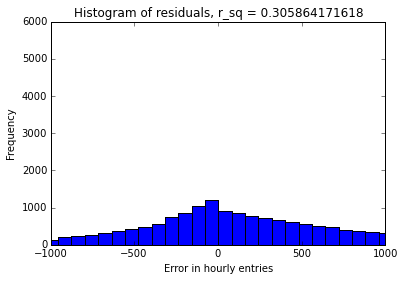

In [35]:
y_mi_ybar = np.exp(Y_train) - np.mean(np.exp(Y_train))
y_mi_pred = np.exp(Y_train) - np.exp(predictions_train)
r_squared_train = 1 - np.sum(y_mi_pred**2)/np.sum(y_mi_ybar**2)

print('R-sq for training set = ' + str(r_squared_train))
plt.figure()
n, bins, patches = plt.hist(np.asarray(y_mi_pred),500)
plt.xlabel('Error in hourly entries')
plt.ylabel('Frequency')
plt.xlim(-1000,1000)
plt.ylim(0,6000)
plt.title('Histogram of residuals, r_sq = ' + str(r_squared_train))

R-sq for testing set = 0.291105341268


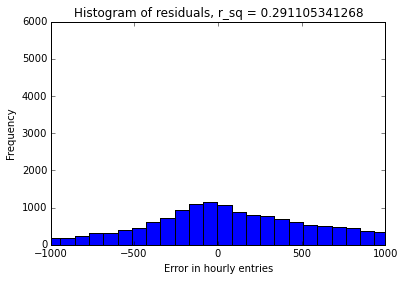

In [36]:
predictions_test = np.dot(X_test, results.params)

y_mi_ybar = np.exp(Y_test) - np.mean(np.exp(Y_test))
y_mi_pred = np.exp(Y_test) - np.exp(predictions_test)
r_squared_test = 1 - np.sum(y_mi_pred**2)/np.sum(y_mi_ybar**2)

print('R-sq for testing set = ' + str(r_squared_test))
plt.figure()
n, bins, patches = plt.hist(np.asarray(y_mi_pred),500)
plt.xlabel('Error in hourly entries')
plt.ylabel('Frequency')
plt.xlim(-1000,1000)
plt.ylim(0,6000)
plt.title('Histogram of residuals, r_sq = ' + str(r_squared_test))

After splitting data in two halves, $R^{2}_{train} = 0.851$ and $R^{2}_{test} = 0.847$ were obtained. Thus suggesting that the linear model captured the trends in data, and did not overfit. 

In [37]:
results_full.params[1:5]

rain       0.286592
precipi   -2.847745
tempi      0.037530
weekday    0.629080
dtype: float64

In [38]:
print(results_full.summary())

                            OLS Regression Results                            
Dep. Variable:        ENTRIESn_hourly   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     119.5
Date:                Sun, 13 Mar 2016   Prob (F-statistic):               0.00
Time:                        16:28:27   Log-Likelihood:                -74494.
No. Observations:               42649   AIC:                         1.495e+05
Df Residuals:                   42405   BIC:                         1.516e+05
Df Model:                         243                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          3.5866      0.054     65.847      0.0

####2.4 What are the parameters (also known as "coefficients" or "weights") of the non-dummy features in your linear regression model?
####Response
The parameters for the four non-dummy variables are, rain: 1.1034, precipitation: -0.2869, temperature: -0.007 and weekday: 1.6320.
####2.5 What is your model’s $R^2$ (coefficients of determination) value?
####Response
The $R^2$ (coefficients of determination) for the full model was $R^{2}=0.858$ 
####2.6 What does this $R^2$  value mean for the goodness of fit for your regression model? Do you think this linear model to predict ridership is appropriate for this dataset, given this R2  value?
####Response

The $R^2 = 0.858$ is close to 1, therefore the model fits the data very well. Based on the $R^2$ value, the model fits the data well. To test this, the same model was fit on half the data that was randomly sampled from the entire data, and tested on the other half. $R^2$s for training and testing tests were $R^{2}_{train} = 0.851$ and $R^{2}_{test} = 0.847$ respectively. 

###Section 3. Visualization
####3.1 One visualization should contain two histograms: one of  ENTRIESn_hourly for rainy days and one of ENTRIESn_hourly for non-rainy days.
####Response: 


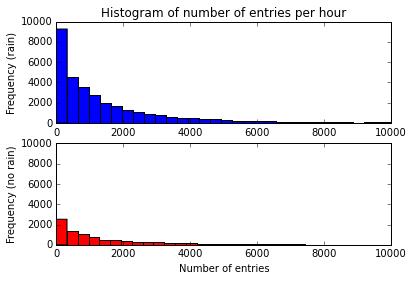

In [39]:
data_rain = np.asarray(turnstile_weather['ENTRIESn_hourly'][ind_rain])
data_nrain = np.asarray(turnstile_weather['ENTRIESn_hourly'][ind_nrain])

plt.subplot(2,1,1)
plt.xlim(0,10000)
plt.ylim(0,10000)
plt.ylabel('Frequency (rain)')
plt.title('Histogram of number of entries per hour')
n, bins, patches = plt.hist(data_rain, 100)
plt.subplot(2,1,2)
plt.xlim(0,10000)
plt.ylim(0,10000)
plt.xlabel('Number of entries ')
plt.ylabel('Frequency (no rain)')
n, bins, patches = plt.hist(data_nrain, 100,color ='red')

####3.2 One visualization can be more freeform. You should feel free to implement something that we discussed in class (e.g., scatter plots, line plots) or attempt to implement something more advanced if you'd like. Some suggestions are:
####Response:

<Container object of 3 artists>

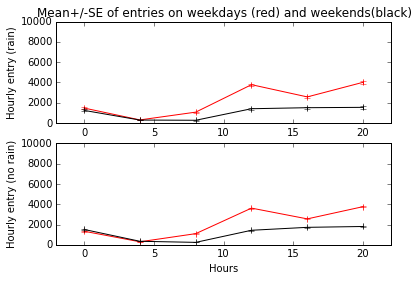

In [40]:
turnstile_weather_short = turnstile_weather.loc[:,['rain', 'hour','weekday','UNIT','ENTRIESn_hourly']]
turnstile_weather_short_sd = turnstile_weather_short.groupby(['rain', 'hour','weekday']).std().reset_index()
turnstile_weather_short_ct = turnstile_weather_short.groupby(['rain', 'hour','weekday']).count().reset_index()
turnstile_weather_short = turnstile_weather_short.groupby(['rain', 'hour','weekday']).mean().reset_index()

turnstile_weather_short['SE_ENTRIESn_hourly'] = turnstile_weather_short_sd.ENTRIESn_hourly/sqrt(turnstile_weather_short_ct.ENTRIESn_hourly)
turnstile_weather_short_rain = turnstile_weather_short.loc[turnstile_weather_short.rain == 1,:]
turnstile_weather_short_nrain = turnstile_weather_short.loc[turnstile_weather_short.rain == 0,:]

tw_r_wd = turnstile_weather_short_rain.loc[turnstile_weather_short.weekday  == 1,:]
tw_r_we = turnstile_weather_short_rain.loc[turnstile_weather_short.weekday  == 0,:]
tw_nr_wd = turnstile_weather_short_nrain.loc[turnstile_weather_short.weekday  == 1,:]
tw_nr_we = turnstile_weather_short_nrain.loc[turnstile_weather_short.weekday  == 0,:]

fig = plt.figure()
plt.subplot(2,1,1)
plt.errorbar(tw_r_wd['hour'], tw_r_wd['ENTRIESn_hourly'], xerr=0, yerr=tw_r_wd['SE_ENTRIESn_hourly'],color = 'red')
plt.errorbar(tw_r_we['hour'], tw_r_we['ENTRIESn_hourly'], xerr=0, yerr=tw_r_we['SE_ENTRIESn_hourly'],color = 'black')
plt.xlim(-2,22)
plt.ylim(0,10000)
plt.ylabel('Hourly entry (rain)')
plt.title('Mean+/-SE of entries on weekdays (red) and weekends(black)')

plt.subplot(2,1,2)
plt.xlim(-2,22)
plt.ylim(0,10000)
plt.xlabel('Hours')
plt.ylabel('Hourly entry (no rain)')
plt.errorbar(tw_nr_wd['hour'], tw_nr_wd['ENTRIESn_hourly'], xerr=0, yerr=tw_nr_wd['SE_ENTRIESn_hourly'],color = 'red')
plt.errorbar(tw_nr_we['hour'], tw_nr_we['ENTRIESn_hourly'], xerr=0, yerr=tw_nr_we['SE_ENTRIESn_hourly'],color = 'black')


   rain  ENTRIESn_hourly  SE_ENTRIESn_hourly
0     0      1845.539439           15.831767
1     1      2028.196035           32.577479


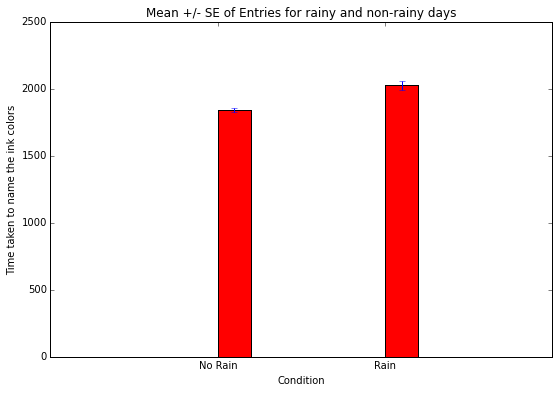

In [41]:
print(rain_mean_SE)
fig1


###Section 4. Conclusion

####4.1 From your analysis and interpretation of the data, do more people ride the NYC subway when it is raining or when it is not raining?  

From the analysis above, more people ride subways when there is rain compared to when there is no rain. On average about 183 more peaple take the subway on a rainy day when compared to non-rainy day. 

####4.2 What analyses lead you to this conclusion? You should use results from both your statistical tests and your linear regression to support your analysis.

From the analysis above, more people ride subways when there is rain compared to when there is no rain. On average about 183 more peaple take the subway on a rainy day when compared to non-rainy day. These conclusions were based on 3 different analysis methods. First a shapiro wilk's test was used to determine if the distribution of data is normal. This test revealed that the data were not normally distributed, therefore a non-parametric test is appropriate. However, as the number of data points were more than 50, a parametric test that assumes normal distribution is applicable. Therefore, 3 seperate analyses were performed. For all the test, a p-value cut off of 0.05 was considered significant i.e. if $p<0.05$, the null hypothesis was rejected. The null hypothesis was that the subway ridership is not affected on a given day if it rains or not. Operationally, rainy and non-rainy days have the same POPULATION mean. ($\mu_{rain} = \mu_{no ~rain} $)

1. Mann Whitney U-test
2. Welch's t-test
3. Linear regression. 
Results from these 3 methods are presented next. 

##### Mann Whitney U-test
Mann Whitney U-test gave $U = 153635120.5$, and $p = 2.74*10^{-6}$. As $p = 2.74*10^{-6}<0.05$, it was concluded that the rainy and non-rainy days have different ridership.

#####Welch t-test
As the number of data points is much larger than 50, a two-tail Welch's t-test is also applicable. From paired two-tail t-test, it appears that the t-statistic was -21.5 and t_critical was 1.96. As the absolute value of t-statistic (5.04) is greater than the critical value (1.96), we conclude that the difference is significant. Futher, the associated $p-value$ was very small ($p \approx 5*10^{-7} << 0.05$). As the $p-value$ was less than the threshold ($\alpha = 0.05$), we reject the null hypothesis. These together indicate that the observed differences are significant, i.e. null hypothesis is to be rejected, i.e. the ridership varies with rain. Further, as p-value for one sided test is half of two sided, it implies that the ridership is higher on rainy days. 

Next confidence interval is computed. Confidence interval is between the ranges of 182 and 183.25, i.e. with 95% confidence we can state that the difference between the rainy and non-rainy days is between 182 and 183.25. As 0 does not lie within the confidence interval, we conclude that the observed differences are significant and the null hypothesis should be rejected. 

#####Linear regression:
Linear regression was used to model relation between features and the data. However, as the data were not distributed normally, a log transform was applied to the dependent measures. However, some of the entries in the data were 0, and log(x) resulted in NaN or Inf values. Therefore, number of entries was transformed into log scale as log(1+x). This is a valid transform, because this results in a one to one transformation. These transformed values of the number of hourly entries were the dependent measure for regression.

Several features or independent measures were explored in regression modeling part. There were some non-dummy variables and some dummy variables. Non-dummy features used in the model are, 
1. Rain: (0/1) indicating if it was raining on that particular day or not.
2. Precipi: Total rainfall during hour.
3. tempi: Temperature at the time of entry. 
4. weekday: (0/1) Indicating if the day is weekday (mon-fri) or a weekend. 

In addition, there were 4 dummy variables included to account for 
1. unit: Unit number at which entry was made.  
2. day_week: Day of the week. Added this as dummy variable because day_week goes from 0 to 6, however, this ordering  does not correlate to ridership. Further, it is anticipated that ridership will be higher during rush hours and lower during 
3. hour: Hour at which entry was made. Hour was taken as a dummy variable, this ordering  does not correlate to ridership
4. Unithour: Unithour represents interaction between unit and hours. It is expected that some stations/units will have peak activity during certain hours. For example, if we take the case of people traveling to new york. Stations farther away from New york are expected to have rush hour during earlier hours, where as stations closer to new york are expected to have more users in hours closer to work hours.
This resulted in a total of 1703 parameters. 

Linear regression was performed using Ordinaly Least squares in the statsmodel package of python. To calculate goodness of fit, $R^2$ was calculated on predictions transformed back to number of entries as $prediction = e^{regression~ prediction}-1$. This yielded a $R^{2}=0.858$. As $R^{2}=0.858$ was very high, there is chance that the data may have been over fitted. Therefore, as a sanity check, another linear regression model was fitted to half of the data randomly sampled from the same data set and tested on the other half. This resulted in  $R^{2}_{train} = 0.851$ and $R^{2}_{test} = 0.847$. Thus indicating that the model was able to predict trends in data well, and chances of overfitting are low. Notes on how model was selected are provided in Reflections section. 

The parameters for the four non-dummy variables are, rain: 1.1034, precipitation: -0.2869, temperature: -0.007 and weekday: 1.6320. These parameters indicate, that on rainy days, there is higher rider ship because the coefficient corresponding to rain is positive. Further, the results from regression give $t_{statistic} = 15.41$ and $p = 0.00<0.05$. As the $p=0.00<<0.05$, it is concluded that this factor is important, and affects the ridership. Further confidence interval is $(0.966,1.241)$, and as $0$ doesnot lie in this interval, it can be said with 95% confidence that the ridership is more on rainy days than non-rainy days. 



###Section 5. Reflection

####5.1 Please discuss potential shortcomings of the methods of your analysis, including: Dataset, Analysis, such as the linear regression model or statistical test.
#### Response:
#####Dataset
The date were grouped into days of the month. However, it would have been interesting if the data were provided for yearly pattern across months. It is expected that during certain months ridership will be higher than normal, for example, during holidays seasons, one would expect more tourists and fewer people traveling for work. An indirect measure to separate tourists and locals could be the mode of purchase or the type of MTA-pass used at the turnstile. If it were a monthly pass, chances are high that it was owned by someone local, while a weekly or daily pass is mostly used by tourists. Further, there are expected to be seasonal trends and year on year growth/decline in ridership. It would be interesting to have access to this data and analyse it. 
#####Analysis
One possible shortcoming of the model is Overfitting of the data. Different models with different number of dummy variables were fitted to the data set. To ensure that there was no overfitting, data were split in to two parts, and the linear model was fitted on first half and tested on second. I was anticipating a divergence between training and test set as number of parameters increased. However, this was not the case. The training and testing data sets both gave similar results. Therefore, chances of overfitting are less. However, having too many categorical variables implies that the model may be too specific for different combinations of parameters (units,hours,weekday, etc)

It is possible that the model fitted one value for each categorical data. To test if the model was too specific, and to estimate number of data points in each category, I took the total number of data points, and divided it by the total number of parameters. This gave a measure of how many independent data points are there in each category, assuming data were equally spread over all categories. These findings are reported in Table below. I, therefore, went with the model with 1703 features. I think this is not too specific and general enough to capture trend in data. However, I am not absolutely certain if this model is the best fit for data. It would be nice to have a quantiative way to choose the best model among these.


$\approx \#$parameters  | $\approx$ $R^2$ | $\approx$ $R_{train}^2$ | $\approx$ $R_{test}^2$ | $\approx$ $\#$data/$\#$params 
------------- | -------------| -------------
 240  | .65| .64 | .66|175
 270  | .75| .75|.75|140
<span style="color:red"> 1700</span>  | <span style="color:red">.85</span>|<span style="color:red">.85</span>|<span style="color:red">.85</span>| <span style="color:red"> 25</span>
 4520  | .91| .90| .91| 9
 10000  | .96+|.95|.96| 4



